# Intro to AI in Pytorch

In this notebook we will explore the basics of doing classification with PyTorch.

First thing we want to demonstrate is that PyTorch can make performing GPU computations very easy. If the GPU is available, using the GPU for matrix multiplication is very easy.

In [3]:
from datetime import datetime
import numpy as np
import torch

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

N = int(1e4)
A_cpu = torch.rand(N, N)

start_time = datetime.now()
A_cpu @ A_cpu
print(f"Total time: {datetime.now() - start_time}")

A_gpu = A_cpu.to(device)
start_time = datetime.now()
A_gpu @ A_gpu
print(f"Total time: {datetime.now() - start_time}")

Total time: 0:00:01.980156
Total time: 0:00:00.979726


We now turn to deep learning. We first create a classification problem. In this dataset, each spiral arm is of a different class.

In [4]:
import random

import math
from IPython import display
from matplotlib import pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim


def plot_scatter(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    # plt.axis('off')

    # _m, _c = 0, '.15'
    # plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    # plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_scatter(X, y)

plt.rc('figure', figsize=(5,5), dpi=100)

In [5]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes

Shapes: X = (3000, 2), Y = (3000,) 


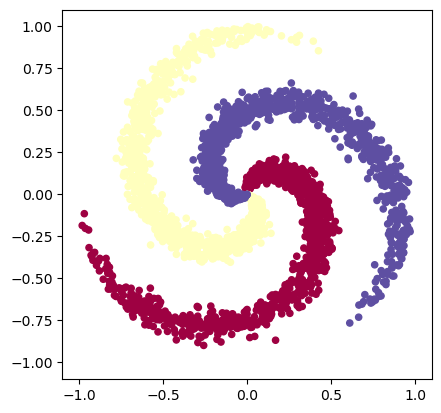

In [6]:
X_cpu = torch.zeros(N * C, D)
y_cpu = torch.zeros(N * C, dtype=torch.long)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    inner_var = torch.linspace((2 * math.pi / C) * (c), 
                               (2 * math.pi / C) * (2 + c), N) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X_cpu[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y_cpu[ix] = c
        index += 1

print(f"Shapes: X = {tuple(X_cpu.size())}, Y = {tuple(y_cpu.size())} ")
plot_scatter(X_cpu, y_cpu)

We now load this data into a Dataset and create a Dataloader

In [8]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_cpu, y_cpu)
train_loader = DataLoader(dataset, batch_size= 256)

The below function encapsulates the training procedure for an epoch (single run over the entire training dataset)

In [10]:
def train(epoch, model, criteria, train_loader, optimizer, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # Optimize
        optimizer.zero_grad()
        output = model(data)
        loss = criteria(output, target)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Train Epoch: {epoch} \tLoss: {loss.item():.6f}')

To see why neural networks are powerful, we will first train a completely linear model. 

In [16]:
H = 100

class LinearNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(D, H),
                    nn.Linear(H,C)
                    )

    def forward(self, x):
        output = self.layers(x)
        return output

model = LinearNetwork().to(device)

learning_rate =  1e-3
decay_factor = 1e-5
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay_factor)

for epoch in range(200):
    train(epoch, model, criteria, train_loader, optimizer, device)

Train Epoch: 0 	Loss: 1.692099
Train Epoch: 10 	Loss: 0.780557
Train Epoch: 20 	Loss: 0.621344
Train Epoch: 30 	Loss: 0.575909
Train Epoch: 40 	Loss: 0.563893
Train Epoch: 50 	Loss: 0.561823
Train Epoch: 60 	Loss: 0.562394
Train Epoch: 70 	Loss: 0.563404
Train Epoch: 80 	Loss: 0.564269
Train Epoch: 90 	Loss: 0.564896
Train Epoch: 100 	Loss: 0.565319
Train Epoch: 110 	Loss: 0.565595
Train Epoch: 120 	Loss: 0.565772
Train Epoch: 130 	Loss: 0.565883
Train Epoch: 140 	Loss: 0.565951
Train Epoch: 150 	Loss: 0.565992
Train Epoch: 160 	Loss: 0.566015
Train Epoch: 170 	Loss: 0.566027
Train Epoch: 180 	Loss: 0.566032
Train Epoch: 190 	Loss: 0.566032


During training the loss does not go down much. Plotting the model's region of classification for each class shows that it is only able to create linear classification rules.

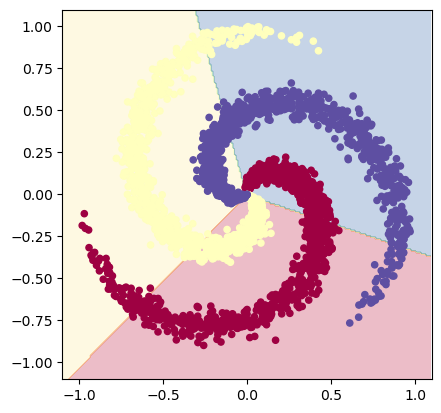

In [17]:
plot_model(X_cpu, y_cpu, model)

We now add a nonlinear activation function, the ReLU and see how the model performs.

In [18]:
dataset = TensorDataset(X_cpu, y_cpu)
train_loader = DataLoader(dataset, batch_size= 256)

H = 100

class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(D, H),
                    nn.ReLU(),
                    nn.Linear(H,C)
                    )

    def forward(self, x):
        output = self.layers(x)
        return output

model = MultiLayerPerceptron().to(device)

learning_rate =  1e-3
decay_factor = 1e-5
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay_factor)

for epoch in range(200):
    train(epoch, model, criteria, train_loader, optimizer, device)

Train Epoch: 0 	Loss: 0.963478
Train Epoch: 10 	Loss: 0.700944
Train Epoch: 20 	Loss: 0.569427
Train Epoch: 30 	Loss: 0.487722
Train Epoch: 40 	Loss: 0.427512
Train Epoch: 50 	Loss: 0.390714
Train Epoch: 60 	Loss: 0.366254
Train Epoch: 70 	Loss: 0.346453
Train Epoch: 80 	Loss: 0.329024
Train Epoch: 90 	Loss: 0.314112
Train Epoch: 100 	Loss: 0.299373
Train Epoch: 110 	Loss: 0.284784
Train Epoch: 120 	Loss: 0.270950
Train Epoch: 130 	Loss: 0.257551
Train Epoch: 140 	Loss: 0.244621
Train Epoch: 150 	Loss: 0.232497
Train Epoch: 160 	Loss: 0.220808
Train Epoch: 170 	Loss: 0.209924
Train Epoch: 180 	Loss: 0.199810
Train Epoch: 190 	Loss: 0.190163


MultiLayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)


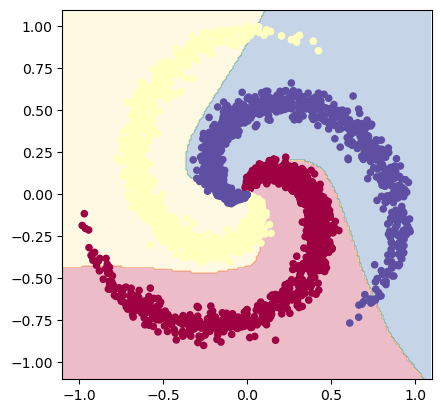

In [19]:
print(model)
plot_model(X_cpu, y_cpu, model)

# Image Classification

We now consider creating a Neural network to run on the classic image classification dataset MNIST. We first load the data

In [20]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

def model_size(model):
    n = 0
    for p in list(model.parameters()):
        n += p.nelement()
    return n

training_data = datasets.MNIST('./data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_data = datasets.MNIST('./data', train=False, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

input_size = 28 * 28    # image dimensions
output_size = 10        # num classes

We display a random sample from the dataset below. The images are of handwritten digits and the goal is to classify the digits in the images correctly.

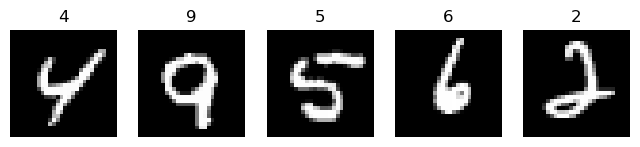

In [21]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [26]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=True)

In [27]:
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # Optimize
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, accuracy_list):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy_list

We can consider a simple Multilayer Perceptron for this task also.

In [42]:
class MLP(nn.Module):
    def __init__(self, input_size, n_feature, output_size) -> None:
        super().__init__()
        self.flatten = nn.Flatten() # flatten 2D tensor into 1D
        self.output = nn.LogSoftmax(dim=1)
        self.layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        out_ = self.output(logits)
        return out_
    


In [43]:
# Training settings 
n_features = 6 # number of feature maps

model = MLP(input_size, n_features, output_size)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(model_size(model)))


accuracy_list = []

for epoch in range(0, 2):
    train(epoch, model)
    accuracy_list = test(model, accuracy_list)

Number of parameters: 669706
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.333506
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.914466
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.569892
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.415636
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.423186
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.376455
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.258540
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.266008
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.333578
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.539172

Test set: Average loss: 0.2605, Accuracy: 9251/10000 (93%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.255092
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.327623
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.232720
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.332572
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.137672
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.144446
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.090823
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.125328
Train Epoch: 1 [51200/

For image classification, the most standard NN model is called a Convolutional Neural Network (CNN). We provide an implementation of a CNN for MNIST below.

In [38]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [41]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(model_size(model_cnn)))

accuracy_list = []
for epoch in range(0, 2):
    train(epoch, model_cnn)
    test(model_cnn, accuracy_list)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.325278
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.974286
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.416230
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.389696
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.590800
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.134053
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.201826
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.188487
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.075848
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.173331

Test set: Average loss: 0.1683, Accuracy: 9519/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.125172
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.122386
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.151328
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.226260
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.061844
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.124405
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.027083
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.247246
Train Epoch: 1 [51200/60